In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
!pip install keras==2.2.4

In [2]:
import os
import numpy as np
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-4
n_classes        = 10
train_batch_size = 32
val_batch_size   = 10
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

The scikit-learn version is 0.17.


Using TensorFlow backend.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [3]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [4]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

#--- Data augmentation
aug = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                         rotation_range=20, 
                         width_shift_range=0.2, height_shift_range=0.2, 
                         horizontal_flip=True, vertical_flip=True, 
                         fill_mode='nearest')

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


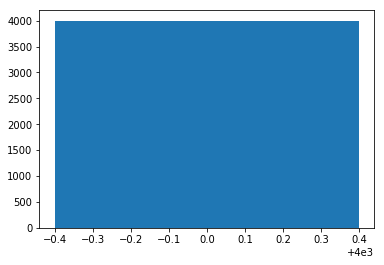

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


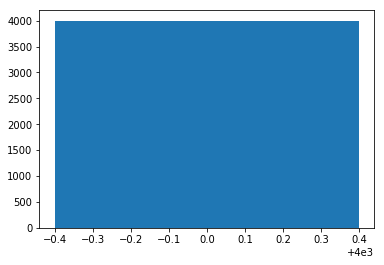

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


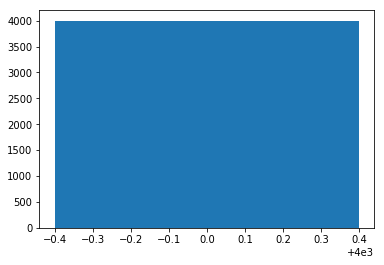

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


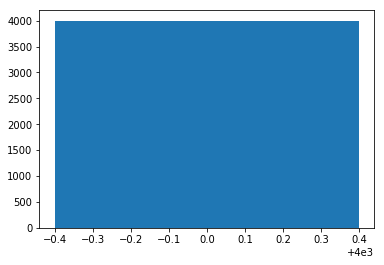

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


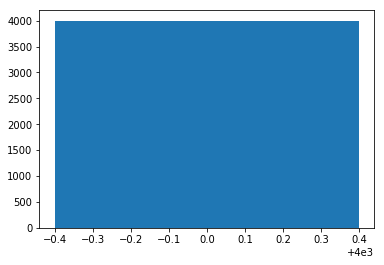

<Figure size 432x288 with 0 Axes>

In [5]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [6]:
def get_squeezenet_ft():
    #=====================================
    # Freezing layers
    #=====================================

    squeezeNetModel = SqueezeNet((32,32,3))

    #freeze layers
    for layer in squeezeNetModel.layers:
        layer.trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    #=====================================
    # Compile model
    #=====================================

    #--- Compile the model
    # It means to configure the model for training.
    # Other types of optimizer:
    #    optimizers.Adam(lr=learning_rate)
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model  = get_squeezenet_ft()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_____________________________________

Now, we compile our model and train it:

In [8]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model  = get_squeezenet_ft()
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    # Training with data augmentation
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 5s 113us/step - loss: 5.1622 - acc: 0.1060 - val_loss: 2.2970 - val_acc: 0.1032
Epoch 2/100
40000/40000 [==============================] - 4s 102us/step - loss: 2.4800 - acc: 0.1094 - val_loss: 2.3019 - val_acc: 0.1003
Epoch 3/100
40000/40000 [==============================] - 4s 102us/step - loss: 2.3479 - acc: 0.1067 - val_loss: 2.3023 - val_acc: 0.1004
Epoch 4/100
40000/40000 [==============================] - 4s 104us/step - loss: 2.3149 - acc: 0.1066 - val_loss: 2.3018 - val_acc: 0.1008
Epoch 5/100
40000/40000 [==============================] - 4s 103us/step - loss: 2.3050 - acc: 0.1082 - val_loss: 2.2998 - val_acc: 0.1021
Epoch 6/100
40000/40000 [==============================] - 5s 119us/step - loss: 2.3005 - acc: 0.1096 - val_loss: 2.2995 - val_acc: 0.1027
Epoch 7/100
4

Epoch 58/100
40000/40000 [==============================] - 5s 121us/step - loss: 2.0978 - acc: 0.2537 - val_loss: 2.0659 - val_acc: 0.2669
Epoch 59/100
40000/40000 [==============================] - 4s 104us/step - loss: 2.0943 - acc: 0.2567 - val_loss: 2.0639 - val_acc: 0.2683
Epoch 60/100
40000/40000 [==============================] - 4s 103us/step - loss: 2.0957 - acc: 0.2560 - val_loss: 2.0622 - val_acc: 0.2696
Epoch 61/100
40000/40000 [==============================] - 4s 109us/step - loss: 2.0906 - acc: 0.2576 - val_loss: 2.0615 - val_acc: 0.2693
Epoch 62/100
40000/40000 [==============================] - 4s 103us/step - loss: 2.0918 - acc: 0.2590 - val_loss: 2.0594 - val_acc: 0.2694
Epoch 63/100
40000/40000 [==============================] - 4s 110us/step - loss: 2.0944 - acc: 0.2564 - val_loss: 2.0604 - val_acc: 0.2702
Epoch 64/100
40000/40000 [==============================] - 5s 115us/step - loss: 2.0917 - acc: 0.2574 - val_loss: 2.0625 - val_acc: 0.2675
Epoch 65/100
40000/4

Epoch 14/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.2708 - acc: 0.1231 - val_loss: 2.2588 - val_acc: 0.1219
Epoch 15/100
40000/40000 [==============================] - 4s 108us/step - loss: 2.2612 - acc: 0.1299 - val_loss: 2.2472 - val_acc: 0.1244
Epoch 16/100
40000/40000 [==============================] - 4s 111us/step - loss: 2.2542 - acc: 0.1343 - val_loss: 2.2426 - val_acc: 0.1276
Epoch 17/100
40000/40000 [==============================] - 5s 116us/step - loss: 2.2469 - acc: 0.1408 - val_loss: 2.2236 - val_acc: 0.1384
Epoch 18/100
40000/40000 [==============================] - 5s 116us/step - loss: 2.2382 - acc: 0.1521 - val_loss: 2.2128 - val_acc: 0.1496
Epoch 19/100
40000/40000 [==============================] - 4s 112us/step - loss: 2.2298 - acc: 0.1565 - val_loss: 2.2110 - val_acc: 0.1548
Epoch 20/100
40000/40000 [==============================] - 4s 108us/step - loss: 2.2222 - acc: 0.1642 - val_loss: 2.2077 - val_acc: 0.1565
Epoch 21/100
40000/4

Epoch 28/100
40000/40000 [==============================] - 5s 123us/step - loss: 2.2619 - acc: 0.1307 - val_loss: 2.2479 - val_acc: 0.1334
Epoch 29/100
40000/40000 [==============================] - 5s 124us/step - loss: 2.2507 - acc: 0.1351 - val_loss: 2.2300 - val_acc: 0.1330
Epoch 30/100
40000/40000 [==============================] - 5s 114us/step - loss: 2.2432 - acc: 0.1370 - val_loss: 2.2181 - val_acc: 0.1386
Epoch 31/100
40000/40000 [==============================] - 5s 121us/step - loss: 2.2313 - acc: 0.1433 - val_loss: 2.1969 - val_acc: 0.1470
Epoch 32/100
40000/40000 [==============================] - 5s 127us/step - loss: 2.2172 - acc: 0.1511 - val_loss: 2.1809 - val_acc: 0.1537
Epoch 33/100
40000/40000 [==============================] - 5s 121us/step - loss: 2.2055 - acc: 0.1550 - val_loss: 2.1721 - val_acc: 0.1643
Epoch 34/100
40000/40000 [==============================] - 5s 114us/step - loss: 2.1998 - acc: 0.1610 - val_loss: 2.1656 - val_acc: 0.1666
Epoch 35/100
40000/4

Epoch 42/100
40000/40000 [==============================] - 5s 117us/step - loss: 2.1691 - acc: 0.1837 - val_loss: 2.1532 - val_acc: 0.1813
Epoch 43/100
40000/40000 [==============================] - 4s 110us/step - loss: 2.1699 - acc: 0.1810 - val_loss: 2.1569 - val_acc: 0.1816
Epoch 44/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.1689 - acc: 0.1859 - val_loss: 2.1508 - val_acc: 0.1831
Epoch 45/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.1630 - acc: 0.1863 - val_loss: 2.1526 - val_acc: 0.1848
Epoch 46/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.1619 - acc: 0.1895 - val_loss: 2.1519 - val_acc: 0.1859
Epoch 47/100
40000/40000 [==============================] - 4s 106us/step - loss: 2.1637 - acc: 0.1878 - val_loss: 2.1482 - val_acc: 0.1876
Epoch 48/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.1621 - acc: 0.1881 - val_loss: 2.1485 - val_acc: 0.1888
Epoch 49/100
40000/4

Epoch 56/100
40000/40000 [==============================] - 4s 108us/step - loss: 2.0909 - acc: 0.2637 - val_loss: 2.0509 - val_acc: 0.2845
Epoch 57/100
40000/40000 [==============================] - 4s 107us/step - loss: 2.0906 - acc: 0.2650 - val_loss: 2.0500 - val_acc: 0.2858
Epoch 58/100
40000/40000 [==============================] - 4s 105us/step - loss: 2.0894 - acc: 0.2652 - val_loss: 2.0498 - val_acc: 0.2818
Epoch 59/100
40000/40000 [==============================] - 4s 105us/step - loss: 2.0870 - acc: 0.2651 - val_loss: 2.0486 - val_acc: 0.2846
Epoch 60/100
40000/40000 [==============================] - 4s 105us/step - loss: 2.0858 - acc: 0.2668 - val_loss: 2.0497 - val_acc: 0.2837
Epoch 61/100
40000/40000 [==============================] - 4s 105us/step - loss: 2.0904 - acc: 0.2645 - val_loss: 2.0502 - val_acc: 0.2868
Epoch 62/100
40000/40000 [==============================] - 4s 105us/step - loss: 2.0865 - acc: 0.2647 - val_loss: 2.0475 - val_acc: 0.2851
Epoch 63/100
40000/4

Finally, let's evaluate on our test set:

In [9]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 2.0218363160133364
Mean Validation accuracy (NORMALIZED): 0.28714000583887095


-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [10]:
def get_squeezenet_ft2():
    squeezeNetModel = SqueezeNet((32,32,3))

    #=====================================
    # Freezing mentioned layers
    #=====================================

    trainable_layer_index = 19
    for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
        squeezeNetModel.layers[i].trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

model = get_squeezenet_ft2()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_9[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [11]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft2()    
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    # Training with data augmentation
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 8s 199us/step - loss: 2.3657 - acc: 0.1563 - val_loss: 2.1477 - val_acc: 0.2350
Epoch 2/100
40000/40000 [==============================] - 7s 184us/step - loss: 2.1195 - acc: 0.2282 - val_loss: 1.9936 - val_acc: 0.3222
Epoch 3/100
40000/40000 [==============================] - 7s 167us/step - loss: 2.0531 - acc: 0.2727 - val_loss: 1.8918 - val_acc: 0.3797
Epoch 4/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.9549 - acc: 0.3215 - val_loss: 1.7618 - val_acc: 0.4315
Epoch 5/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.8505 - acc: 0.3544 - val_loss: 1.6496 - val_acc: 0.4389
Epoch 6/100
40000/40000 [==============================] - 7s 165us/step - loss: 1.7884 - acc: 0.3707 - val_loss: 1.6109 - val_acc: 0.4553
Epoch 7/100
4

Epoch 58/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.0673 - acc: 0.6181 - val_loss: 1.5291 - val_acc: 0.5124
Epoch 59/100
40000/40000 [==============================] - 7s 170us/step - loss: 1.0608 - acc: 0.6196 - val_loss: 1.5571 - val_acc: 0.5182
Epoch 60/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0516 - acc: 0.6214 - val_loss: 1.5548 - val_acc: 0.5149
Epoch 61/100
40000/40000 [==============================] - 7s 177us/step - loss: 1.0409 - acc: 0.6244 - val_loss: 1.5887 - val_acc: 0.5093
Epoch 62/100
40000/40000 [==============================] - 7s 170us/step - loss: 1.0350 - acc: 0.6271 - val_loss: 1.5692 - val_acc: 0.5141
Epoch 63/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.0254 - acc: 0.6320 - val_loss: 1.5882 - val_acc: 0.5154
Epoch 64/100
40000/40000 [==============================] - 7s 163us/step - loss: 1.0142 - acc: 0.6336 - val_loss: 1.6141 - val_acc: 0.5137
Epoch 65/100
40000/4

Epoch 14/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.5318 - acc: 0.4700 - val_loss: 1.4710 - val_acc: 0.4922
Epoch 15/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.5210 - acc: 0.4749 - val_loss: 1.4678 - val_acc: 0.4900
Epoch 16/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.5017 - acc: 0.4800 - val_loss: 1.4590 - val_acc: 0.4970
Epoch 17/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.4825 - acc: 0.4881 - val_loss: 1.4547 - val_acc: 0.4987
Epoch 18/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.4667 - acc: 0.4936 - val_loss: 1.4573 - val_acc: 0.4913
Epoch 19/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.4584 - acc: 0.4994 - val_loss: 1.4581 - val_acc: 0.4953
Epoch 20/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.4440 - acc: 0.5003 - val_loss: 1.4391 - val_acc: 0.4997
Epoch 21/100
40000/4

Epoch 28/100
40000/40000 [==============================] - 7s 169us/step - loss: 1.3389 - acc: 0.5340 - val_loss: 1.4270 - val_acc: 0.5124
Epoch 29/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.3254 - acc: 0.5378 - val_loss: 1.4135 - val_acc: 0.5121
Epoch 30/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.3155 - acc: 0.5413 - val_loss: 1.4140 - val_acc: 0.5165
Epoch 31/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.3039 - acc: 0.5456 - val_loss: 1.4176 - val_acc: 0.5174
Epoch 32/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.2974 - acc: 0.5466 - val_loss: 1.4132 - val_acc: 0.5151
Epoch 33/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.2859 - acc: 0.5520 - val_loss: 1.4390 - val_acc: 0.5125
Epoch 34/100
40000/40000 [==============================] - 7s 168us/step - loss: 1.2729 - acc: 0.5549 - val_loss: 1.4183 - val_acc: 0.5155
Epoch 35/100
40000/4

Epoch 42/100
40000/40000 [==============================] - 7s 185us/step - loss: 1.2094 - acc: 0.5692 - val_loss: 1.4554 - val_acc: 0.5193
Epoch 43/100
40000/40000 [==============================] - 8s 195us/step - loss: 1.2061 - acc: 0.5729 - val_loss: 1.4357 - val_acc: 0.5187
Epoch 44/100
40000/40000 [==============================] - 8s 198us/step - loss: 1.1922 - acc: 0.5742 - val_loss: 1.4315 - val_acc: 0.5132
Epoch 45/100
40000/40000 [==============================] - 8s 192us/step - loss: 1.1829 - acc: 0.5762 - val_loss: 1.4692 - val_acc: 0.5138
Epoch 46/100
40000/40000 [==============================] - 8s 206us/step - loss: 1.1725 - acc: 0.5817 - val_loss: 1.4619 - val_acc: 0.5203
Epoch 47/100
40000/40000 [==============================] - 8s 201us/step - loss: 1.1609 - acc: 0.5858 - val_loss: 1.4681 - val_acc: 0.5166
Epoch 48/100
40000/40000 [==============================] - 8s 205us/step - loss: 1.1561 - acc: 0.5873 - val_loss: 1.4614 - val_acc: 0.5166
Epoch 49/100
40000/4

Epoch 56/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0883 - acc: 0.6111 - val_loss: 1.5601 - val_acc: 0.5082
Epoch 57/100
40000/40000 [==============================] - 7s 172us/step - loss: 1.0801 - acc: 0.6126 - val_loss: 1.5351 - val_acc: 0.5076
Epoch 58/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0712 - acc: 0.6147 - val_loss: 1.5663 - val_acc: 0.5062
Epoch 59/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0613 - acc: 0.6176 - val_loss: 1.5740 - val_acc: 0.5056
Epoch 60/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0540 - acc: 0.6221 - val_loss: 1.6195 - val_acc: 0.5032
Epoch 61/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0446 - acc: 0.6217 - val_loss: 1.6082 - val_acc: 0.5057
Epoch 62/100
40000/40000 [==============================] - 7s 171us/step - loss: 1.0356 - acc: 0.6272 - val_loss: 1.6135 - val_acc: 0.5043
Epoch 63/100
40000/4

Finally, let's evaluate on our test set:

In [12]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 2.1649977488458156
Mean Validation accuracy (NORMALIZED): 0.4909800066113473


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [12]:
def get_squeezenet_ft3():
    squeezeNetModel = SqueezeNet((32,32,3))

    for layer in squeezeNetModel.layers:
        layer.trainable = True       #by default they are all trainable, but just for clarification

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    print("--- Compiling model")
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model = get_squeezenet_ft3()
model.summary()

--- Compiling model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_15[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_________________________________________________________________________________________

Now, we compile our model and train it:

In [ ]:
from time import time

#=====================================
# Tensorboard callback
#=====================================

print("--- Preparing tensorboard")
log_dir = "logs/{}".format(time())
print("Log Dir: ", log_dir)
tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)

#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)
scores = []

for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft3()
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    #print("Optimizer:", opt)
    print("================================================")
          
    #--- Training with data augmentation
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
          
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

--- Preparing tensorboard
Log Dir:  logs/1542642629.2368855
--- Start training
--- Compiling model
Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 16s 392us/step - loss: 2.2826 - acc: 0.1584 - val_loss: 2.0243 - val_acc: 0.3246
Epoch 2/100
40000/40000 [==============================] - 15s 367us/step - loss: 1.8054 - acc: 0.3678 - val_loss: 1.4007 - val_acc: 0.5291
Epoch 3/100
40000/40000 [==============================] - 14s 357us/step - loss: 1.4157 - acc: 0.5390 - val_loss: 1.1710 - val_acc: 0.6234
Epoch 4/100
40000/40000 [==============================] - 14s 361us/step - loss: 1.1942 - acc: 0.6240 - val_loss: 1.0712 - val_acc: 0.6540
Epoch 5/100
40000/40000 [==============================] - 14s 356us/step - loss: 1.0527 - acc: 0.6676 - val_loss: 1.0020 - val_acc: 0.6721
Epoch 6/100
40000/40000 [=======================

40000/40000 [==============================] - 14s 343us/step - loss: 0.6588 - acc: 0.7851 - val_loss: 0.9258 - val_acc: 0.7197
Epoch 12/100
40000/40000 [==============================] - 14s 343us/step - loss: 0.6152 - acc: 0.7976 - val_loss: 0.9212 - val_acc: 0.7192
Epoch 13/100
40000/40000 [==============================] - 14s 343us/step - loss: 0.5794 - acc: 0.8088 - val_loss: 0.9094 - val_acc: 0.7312
Epoch 14/100
40000/40000 [==============================] - 14s 349us/step - loss: 0.5504 - acc: 0.8180 - val_loss: 0.9613 - val_acc: 0.7307
Epoch 15/100
40000/40000 [==============================] - 14s 347us/step - loss: 0.5158 - acc: 0.8286 - val_loss: 0.9091 - val_acc: 0.7346
Epoch 16/100
40000/40000 [==============================] - 14s 343us/step - loss: 0.4845 - acc: 0.8389 - val_loss: 1.0272 - val_acc: 0.7258
Epoch 17/100
40000/40000 [==============================] - 14s 344us/step - loss: 0.4599 - acc: 0.8471 - val_loss: 0.9688 - val_acc: 0.7326
Epoch 18/100
40000/40000 [

Finally, let's evaluate on our validation set:

In [15]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.967186710528987
Mean Validation accuracy (NORMALIZED): 0.7352199997365474


In [16]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [17]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [18]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

Test loss: 2.181651924790132
Test accuracy (NORMALIZED): 0.729099999576807
